# MLPs for Image Classification

> *Deep Learning*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

#### *Description*

Given an image of a fashion item, build a deep learning model that recognizes the fashion item. You must use at least 2 different architectures, one with MLPs and one with CNNs. Use the Fashion-MNIST dataset to train and evaluate your models. More information about the task and the dataset can be found at <a href="https://github.com/zalandoresearch/fashion-mnist">https://github.com/zalandoresearch/fashion-mnist</a>. The dataset is also available from Tensorflow.

### 1. Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np
import gc
import tensorflow as tf
import keras
from tensorflow.keras import backend as K
from keras.datasets import fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils.vis_utils import plot_model

print("Tensorflow version " + tf.__version__)

Tensorflow version 2.13.0


### 2. Data

The Fashion-MNIST dataset is a collection of 70,000 images of clothing items, such as t-shirts, dresses, and shoes, each with a resolution of 28x28 pixels. It is commonly used as a benchmark dataset in machine learning and computer vision research, serving as a replacement for the traditional MNIST dataset of handwritten digits.</p>

The dataset was created by researchers at the Zalando Research group in 2017, with the aim of providing a more challenging and realistic dataset for image classification tasks. It has become a popular dataset for testing and comparing different machine learning algorithms, and has been used in a wide range of applications, such as object detection, image segmentation, and generative models.

In [2]:
# Load the Fashion-MNIST dataset in Train/Test
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

print("\nThe x_train shape is:", x_train.shape)
print("The x_test shape is :", x_test.shape)


The x_train shape is: (60000, 28, 28)
The x_test shape is : (10000, 28, 28)


#### 2.1 Preprocess the data

* Reshape the data tables by flattening the images dimensions.
* Normalize the values to [0, 255] --> [0, 1]  
* Convert target variables to categorical

In [3]:
# Preprocess the data
x_train = x_train.reshape(60000, 784).astype('float32') / 255
x_test = x_test.reshape(10000, 784).astype('float32') / 255
y_train = keras.utils.to_categorical(y_train, num_classes=10)
y_test = keras.utils.to_categorical(y_test, num_classes=10)

### 3. Define Useful Functions

#### 3.1 Plot Functions

In [33]:
def print_results(hs, evaluate_model, metric='val_loss'):
    # Find the index and value of the minimum validation loss in the training history
    min_val_loss, idx = min((val, idx) for (idx, val) in enumerate(hs.history[metric]))

    # Print information about the best epoch
    print('Best Epoch: ', idx + 1)
    print("---")

    # Print loss values
    print("Train Loss     : {0:.5f}".format(hs.history['loss'][idx]))
    print("Validation Loss: {0:.5f}".format(hs.history['val_loss'][idx]))
    print("Test Loss      : {0:.5f}".format(evaluate_model[0]))
    print("---")

    # Print accuracy values
    print("Train Accuracy     : {0:.5f}".format(hs.history['accuracy'][idx]))
    print("Validation Accuracy: {0:.5f}".format(hs.history['val_accuracy'][idx]))
    print("Test Accuracy      : {0:.5f}".format(evaluate_model[1]))


def plot_history(hs, epochs, metric):
    # Print an empty line for better visual separation
    print()

    # Set the style and size of the plot
    plt.style.use('ggplot')
    plt.rcParams['figure.figsize'] = [16, 8]
    plt.rcParams['font.size'] = 16

    # Clear the current plot
    plt.clf()

    # Iterate through each label in the history dictionary
    for label in hs:
        # Plot the training and validation metric values for each label
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric), linewidth=2)
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric), linewidth=2)

    # Set x-axis ticks at intervals of 10% of total epochs
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks[0] += 1
    plt.xticks(x_ticks)

    # Set y-axis limit based on the metric being plotted
    plt.ylim((0, 1)) if metric == 'loss' else plt.ylim((0, 100))

    # Set x-axis and y-axis labels
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric == 'loss' else 'Accuracy')

    # Display a legend
    plt.legend()

    # Show the plot
    plt.show()


def plot_cm(y_pred, y_test):
    # Convert predictions to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    # Convert test data to class labels
    y_test_classes = np.argmax(y_test, axis=1)

    # Create a confusion matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    # Define the class names
    class_names = np.array(['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
                            'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'])

    # Plot the confusion matrix
    plt.rcParams['figure.figsize'] = [14, 10]
    sns.heatmap(cm, annot=True, fmt='d', cmap="crest", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.show()


#### 3.2 Clean Function

In [5]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()

### 4. Model Architectures (MLPs)

In this section we will create different architectures of a **Multilayer Perceptron model**. We will focus especially on the number of hidden layers and the optimizers.

We will train all of our models in **100 epochs**. So, we will be able to plot how the model behaves. In case of overtraing we will use a callback to save the best weights. Then, we will use the model with best weights for evaluation and to make predictions.

All of our architectures are sequential.

#### 4.1 **MLP classifier 1 - Model 1**

> **Hidden layers:** Two <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Stochastic Gradient Descent - 0.01 learning rate - 0.9 momentum

##### 4.1.1 Creation

In [18]:
# Ensure reproducible experiments and results
np.random.seed(99) # Numpy random seed
tf.random.set_seed(999) # Tensorflow random seed

# Define the MLP architecture
model = Sequential(name = 'Model_1')
model.add(Dense(512, activation='relu', name = 'Layer', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2, name = 'Dropout_1'))
model.add(Dense(256, activation='relu', name = 'Layer_2'))
model.add(Dropout(0.2, name = 'Dropout_2'))
model.add(Dense(10,  name = 'Output_layer', activation='softmax'))

# Optimizer
optimizer = SGD(learning_rate = 0.01, momentum = 0.9, nesterov = True)

# Compile the model
model.compile(loss= 'categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (Dense)               (None, 512)               401920    
                                                                 
 Dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 Layer_2 (Dense)             (None, 256)               131328    
                                                                 
 Dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 Output_layer (Dense)        (None, 10)                2570      
                                                                 
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


##### 4.1.2 Training

In [19]:
# Create callback to get the best weights after training
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_model_1.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Train the model
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          validation_split = 0.1,
          verbose=1,
          callbacks=callbacks)

Epoch 1/100
422/422 [==============================] - 2s 5ms/step - loss: 0.6632 - accuracy: 0.7696 - val_loss: 0.4500 - val_accuracy: 0.8422
Epoch 2/100
422/422 [==============================] - 2s 5ms/step - loss: 0.4532 - accuracy: 0.8414 - val_loss: 0.4069 - val_accuracy: 0.8502
Epoch 3/100
422/422 [==============================] - 2s 5ms/step - loss: 0.4082 - accuracy: 0.8535 - val_loss: 0.3707 - val_accuracy: 0.8670
Epoch 4/100
422/422 [==============================] - 2s 5ms/step - loss: 0.3783 - accuracy: 0.8634 - val_loss: 0.3636 - val_accuracy: 0.8707
Epoch 5/100
422/422 [==============================] - 2s 4ms/step - loss: 0.3604 - accuracy: 0.8689 - val_loss: 0.3514 - val_accuracy: 0.8750
Epoch 6/100
422/422 [==============================] - 2s 5ms/step - loss: 0.3433 - accuracy: 0.8755 - val_loss: 0.3365 - val_accuracy: 0.8777
Epoch 7/100
422/422 [==============================] - 2s 5ms/step - loss: 0.3296 - accuracy: 0.8801 - val_loss: 0.3319 - val_accuracy: 0.8802

Epoch 58/100
422/422 [==============================] - 3s 6ms/step - loss: 0.1339 - accuracy: 0.9492 - val_loss: 0.3193 - val_accuracy: 0.8970
Epoch 59/100
422/422 [==============================] - 3s 6ms/step - loss: 0.1329 - accuracy: 0.9492 - val_loss: 0.3154 - val_accuracy: 0.9003
Epoch 60/100
422/422 [==============================] - 2s 6ms/step - loss: 0.1259 - accuracy: 0.9532 - val_loss: 0.3178 - val_accuracy: 0.9033
Epoch 61/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1297 - accuracy: 0.9509 - val_loss: 0.3104 - val_accuracy: 0.9002
Epoch 62/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1270 - accuracy: 0.9520 - val_loss: 0.3188 - val_accuracy: 0.8990
Epoch 63/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1251 - accuracy: 0.9517 - val_loss: 0.3403 - val_accuracy: 0.8955
Epoch 64/100
422/422 [==============================] - 2s 5ms/step - loss: 0.1237 - accuracy: 0.9527 - val_loss: 0.3418 - val_accuracy:

##### 4.1.3 Evaluation

Best Epoch:  33
---
Train Loss     : 0.19111
Validation Loss: 0.28711
Test Loss      : 0.30139
---
Train Accuracy     : 0.92781
Validation Accuracy: 0.89767
Test Accuracy      : 0.89790



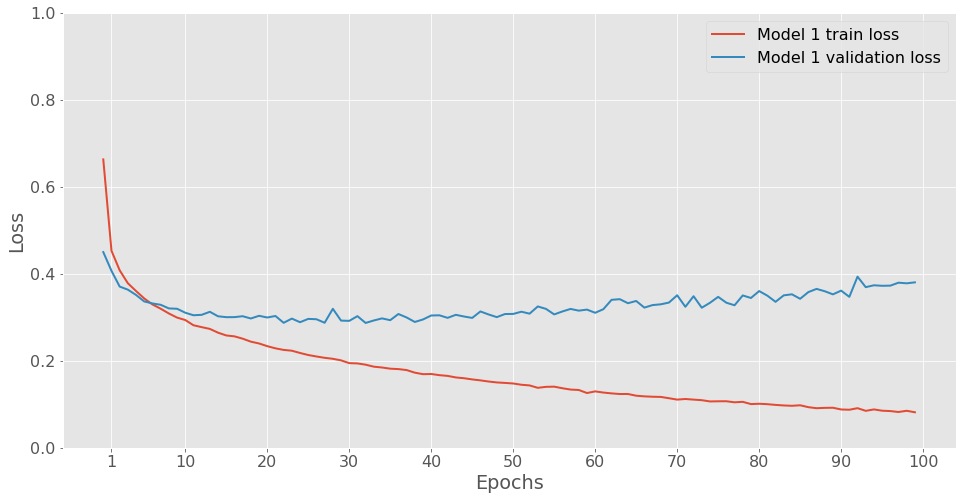

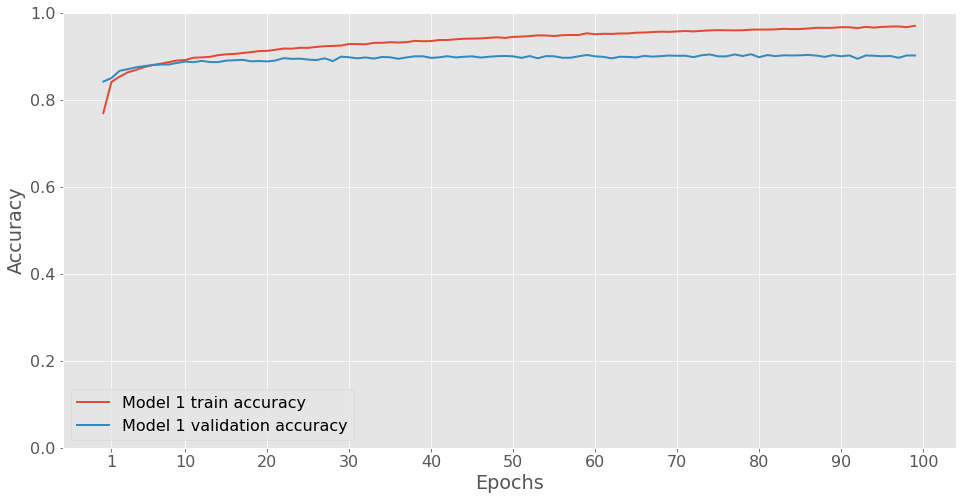

In [20]:
# Load the best weights
model.load_weights('./Checkpoints/best_weights_model_1.h5')

# Evaluate model with best weights on test data and show all the results.
score = model.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(history, score)

# Plot train and validation error per epoch.
plot_history(hs={'Model 1': history}, epochs=100, metric='loss')
plot_history(hs={'Model 1': history}, epochs=100, metric='accuracy')

##### 4.1.4 Predictions

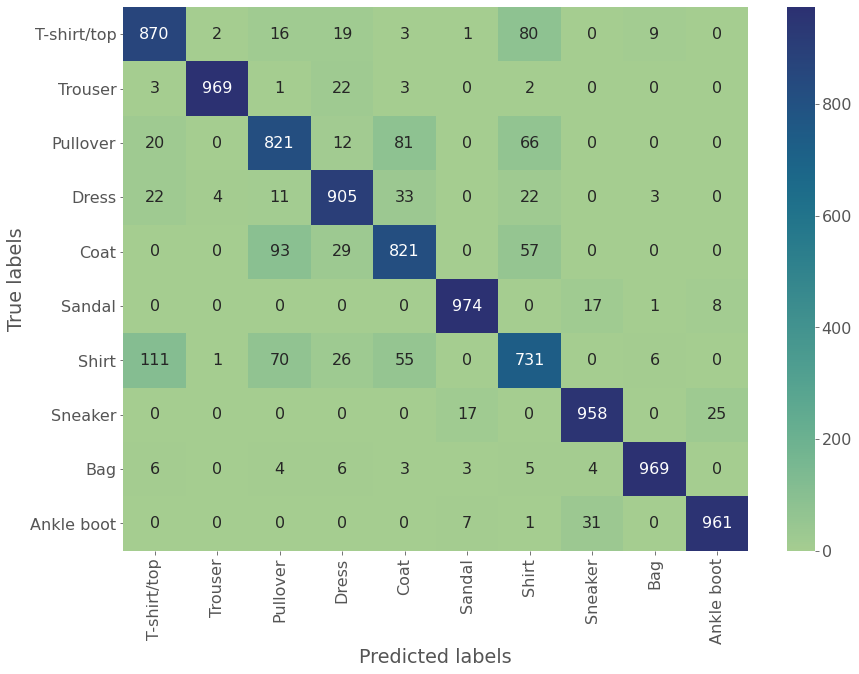

In [21]:
# Predict labels for test data
y_pred = model.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model)

##### *Remarks*

- In **epoch 33**, Model 1 achieves its lowest validation loss. However, as the training progresses, the model begins to exhibit signs of overfitting.

- The model attains an accuracy of **89.7%**. The heatmap visualization indicates that the majority of errors occur between Shirts and T-shirt/top, which aligns with our expectations. 

#### 4.2 **MLP classifier 2 - Model 2**

> **Hidden layers:** Two <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.2 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Adam - 0.0005 learning rate

##### 4.2.1 Creation

In [22]:
# Ensure reproducible experiments and results
np.random.seed(99) # Numpy random seed
tf.random.set_seed(999) # Tensorflow random seed

# Define the MLP architecture
model = Sequential(name = 'Model_2')
model.add(Dense(256, activation='relu', name = 'Layer', kernel_initializer='glorot_uniform', input_shape=(x_train.shape[1],)))
model.add(Dropout(0.2, name = 'Dropout_1'))
model.add(Dense(128, activation='relu',  name = 'Layer_2', kernel_initializer='glorot_uniform'))
model.add(Dropout(0.2, name = 'Dropout_2'))
model.add(Dense(10,  name = 'Output_layer', activation='softmax'))

# Optimizer
optimizer = Adam(learning_rate = 0.0005)

# Compile the model
model.compile(loss= 'categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (Dense)               (None, 256)               200960    
                                                                 
 Dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 Layer_2 (Dense)             (None, 128)               32896     
                                                                 
 Dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 Output_layer (Dense)        (None, 10)                1290      
                                                                 
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
_________________________________________________________________


##### 4.2.2 Training

In [23]:
# Create callback to get the best weights after training
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_model_2.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Train the model
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          validation_split = 0.1,
          verbose=1,
          callbacks=callbacks)

Epoch 1/100
422/422 [==============================] - 2s 3ms/step - loss: 0.6439 - accuracy: 0.7779 - val_loss: 0.4222 - val_accuracy: 0.8478
Epoch 2/100
422/422 [==============================] - 1s 3ms/step - loss: 0.4330 - accuracy: 0.8466 - val_loss: 0.3905 - val_accuracy: 0.8568
Epoch 3/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3867 - accuracy: 0.8610 - val_loss: 0.3483 - val_accuracy: 0.8693
Epoch 4/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3611 - accuracy: 0.8692 - val_loss: 0.3596 - val_accuracy: 0.8693
Epoch 5/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3389 - accuracy: 0.8758 - val_loss: 0.3449 - val_accuracy: 0.8750
Epoch 6/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3247 - accuracy: 0.8819 - val_loss: 0.3303 - val_accuracy: 0.8783
Epoch 7/100
422/422 [==============================] - 1s 3ms/step - loss: 0.3101 - accuracy: 0.8881 - val_loss: 0.3183 - val_accuracy: 0.8795

Epoch 58/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1286 - accuracy: 0.9509 - val_loss: 0.3548 - val_accuracy: 0.9000
Epoch 59/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1249 - accuracy: 0.9519 - val_loss: 0.3620 - val_accuracy: 0.8995
Epoch 60/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1252 - accuracy: 0.9519 - val_loss: 0.3567 - val_accuracy: 0.9038
Epoch 61/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1244 - accuracy: 0.9524 - val_loss: 0.3541 - val_accuracy: 0.8992
Epoch 62/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1255 - accuracy: 0.9515 - val_loss: 0.3529 - val_accuracy: 0.9030
Epoch 63/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1198 - accuracy: 0.9536 - val_loss: 0.3648 - val_accuracy: 0.8997
Epoch 64/100
422/422 [==============================] - 1s 3ms/step - loss: 0.1201 - accuracy: 0.9532 - val_loss: 0.3593 - val_accuracy:

##### 4.2.3 Evaluation

Best Epoch:  17
---
Train Loss     : 0.23798
Validation Loss: 0.28841
Test Loss      : 0.31087
---
Train Accuracy     : 0.91130
Validation Accuracy: 0.89400
Test Accuracy      : 0.89230



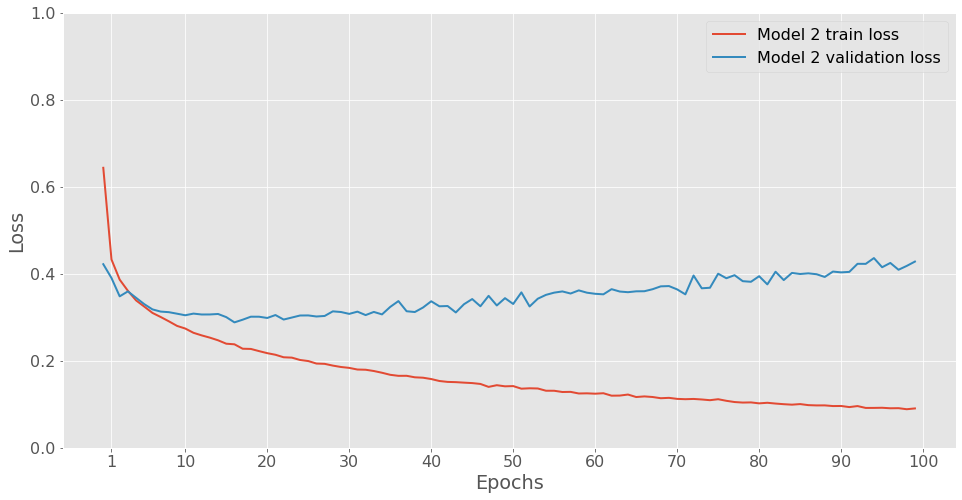

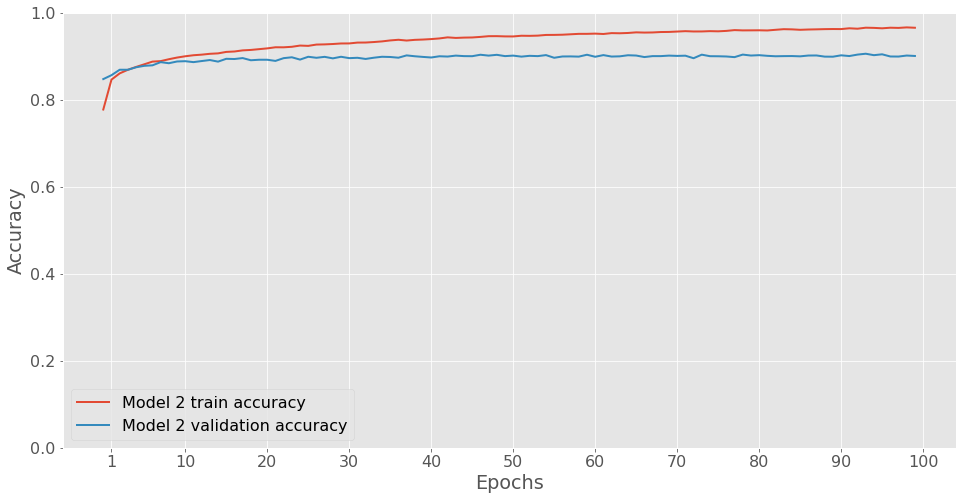

In [24]:
# Load the best weights
model.load_weights('./Checkpoints/best_weights_model_2.h5')

# Evaluate model with best weights on test data and show all the results.
score = model.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(history, score)

# Plot train and validation error per epoch.
plot_history(hs={'Model 2': history}, epochs=100, metric='loss')
plot_history(hs={'Model 2': history}, epochs=100, metric='accuracy')

##### 4.2.4 Predictions

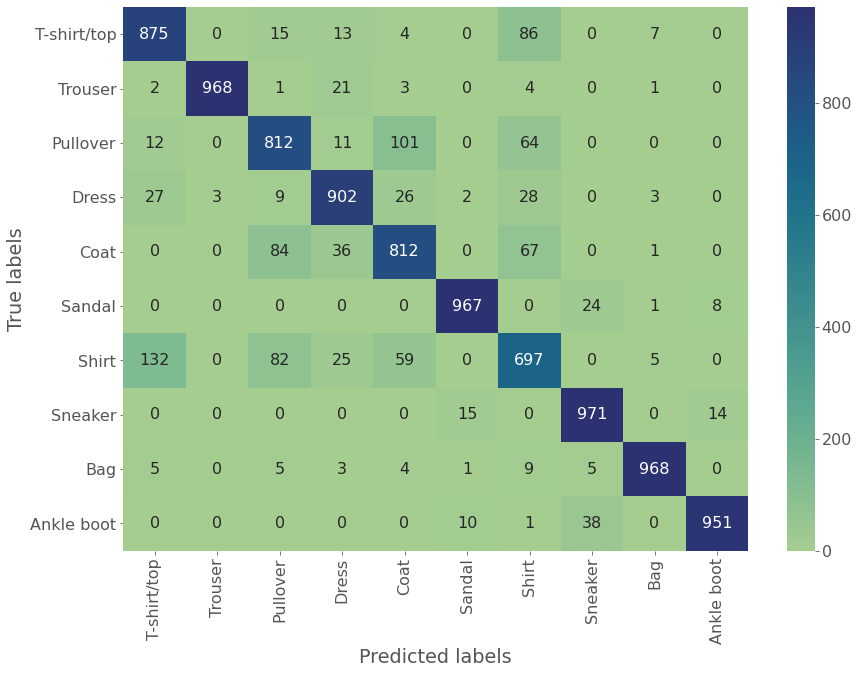

In [25]:
# Predict labels for test data
y_pred = model.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model)

##### *Remarks*

- In **epoch 17**, Model 2 achieves its lowest validation loss. Notably, with the Adam optimizer, the model converges more rapidly compared to the SGD optimizer.

- However, as training progresses, overfitting becomes evident. The model achieves an accuracy of **89.2%**.

- While we don't achieve a higher accuracy with Model 2, the noteworthy aspect is the faster convergence achieved with the chosen optimization approach.

#### 4.3 **MLP classifier 3 - Model 3**

> **Hidden layers:** Three <br>
> **Activation function:** Relu and Softmax(output) <br>
> **Dropout:** 0.3 <br>
> **Loss function:** Categorical Cross Entropy <br>
> **Optimizer:** Adam - 0.001 learning rate <br>
> **Batch Normalization**


##### 4.3.1 Creation

In [27]:
# Ensure reproducible experiments and results
np.random.seed(99) # Numpy random seed
tf.random.set_seed(999) # Tensorflow random seed

# Define the MLP architecture
model = Sequential(name = 'Model_3')
model.add(Dense(512, activation='relu', name = 'Layer', kernel_initializer='glorot_uniform', input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.3, name = 'Dropout_1'))
model.add(Dense(256, activation='relu',  name = 'Layer_2', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3, name = 'Dropout_2'))
model.add(Dense(128, activation='relu',  name = 'Layer_3', kernel_initializer='glorot_uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.3, name = 'Dropout_3'))
model.add(Dense(10,  name = 'Output_layer', activation='softmax'))

# Optimizer
optimizer = Adam(learning_rate = 0.001)

# Compile the model
model.compile(loss= 'categorical_crossentropy',
              optimizer = optimizer,
              metrics=['accuracy'])

# Model Summary
model.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer (Dense)               (None, 512)               401920    
                                                                 
 batch_normalization_3 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 Dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 Layer_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_4 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 Dropout_2 (Dropout)         (None, 256)               0   

##### 4.3.2 Training

In [28]:
# Create callback to get the best weights after training
callbacks = [ModelCheckpoint(filepath='./Checkpoints/best_weights_model_3.h5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=True)]

# Train the model
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=100,
          validation_split = 0.1,
          verbose=1,
          callbacks=callbacks)

Epoch 1/100
422/422 [==============================] - 4s 7ms/step - loss: 0.5874 - accuracy: 0.7941 - val_loss: 0.4396 - val_accuracy: 0.8313
Epoch 2/100
422/422 [==============================] - 3s 6ms/step - loss: 0.4427 - accuracy: 0.8413 - val_loss: 0.4015 - val_accuracy: 0.8540
Epoch 3/100
422/422 [==============================] - 3s 6ms/step - loss: 0.4123 - accuracy: 0.8507 - val_loss: 0.4042 - val_accuracy: 0.8487
Epoch 4/100
422/422 [==============================] - 3s 6ms/step - loss: 0.3887 - accuracy: 0.8589 - val_loss: 0.3777 - val_accuracy: 0.8642
Epoch 5/100
422/422 [==============================] - 3s 6ms/step - loss: 0.3725 - accuracy: 0.8645 - val_loss: 0.3581 - val_accuracy: 0.8700
Epoch 6/100
422/422 [==============================] - 3s 6ms/step - loss: 0.3652 - accuracy: 0.8651 - val_loss: 0.3582 - val_accuracy: 0.8702
Epoch 7/100
422/422 [==============================] - 3s 6ms/step - loss: 0.3554 - accuracy: 0.8690 - val_loss: 0.3559 - val_accuracy: 0.8685

Epoch 58/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2086 - accuracy: 0.9218 - val_loss: 0.3075 - val_accuracy: 0.8940
Epoch 59/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2060 - accuracy: 0.9231 - val_loss: 0.3185 - val_accuracy: 0.8953
Epoch 60/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2038 - accuracy: 0.9237 - val_loss: 0.3200 - val_accuracy: 0.8967
Epoch 61/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2034 - accuracy: 0.9232 - val_loss: 0.3077 - val_accuracy: 0.8957
Epoch 62/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2075 - accuracy: 0.9225 - val_loss: 0.3092 - val_accuracy: 0.8922
Epoch 63/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2001 - accuracy: 0.9253 - val_loss: 0.3081 - val_accuracy: 0.8972
Epoch 64/100
422/422 [==============================] - 3s 7ms/step - loss: 0.2064 - accuracy: 0.9232 - val_loss: 0.3099 - val_accuracy:

##### 4.3.3 Evaluation

Best Epoch:  33
---
Train Loss     : 0.25060
Validation Loss: 0.29336
Test Loss      : 0.31580
---
Train Accuracy     : 0.90757
Validation Accuracy: 0.89517
Test Accuracy      : 0.88670



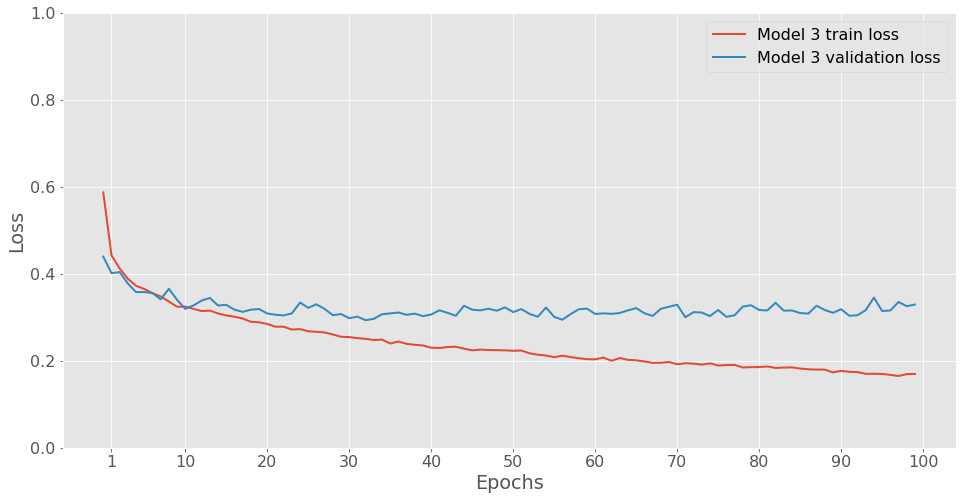

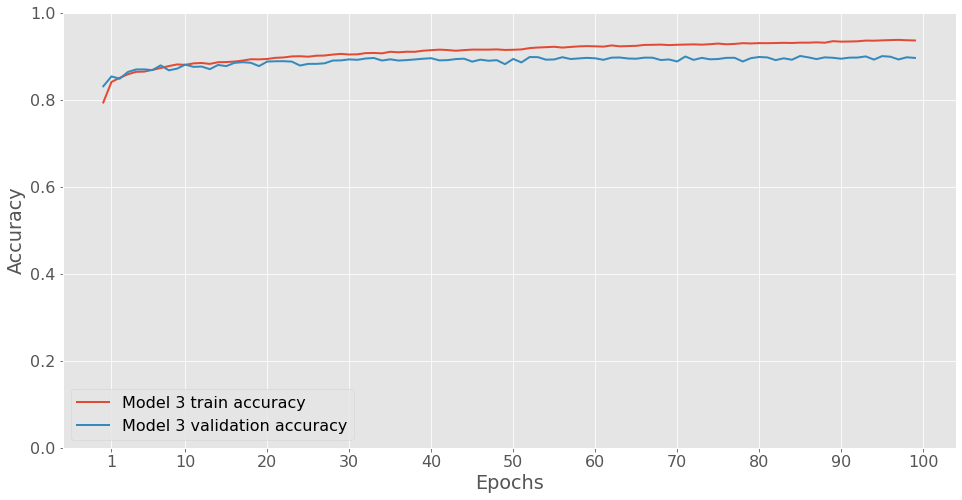

In [31]:
# Load the best weights
model.load_weights('./Checkpoints/best_weights_model_3.h5')

# Evaluate model with best weights on test data and show all the results.
score = model.evaluate(x_test, y_test, verbose=0)

# Print results
print_results(history, score)

# Plot train and validation error per epoch.
plot_history(hs={'Model 3': history}, epochs=100, metric='loss')
plot_history(hs={'Model 3': history}, epochs=100, metric='accuracy')

##### 4.3.4 Predictions

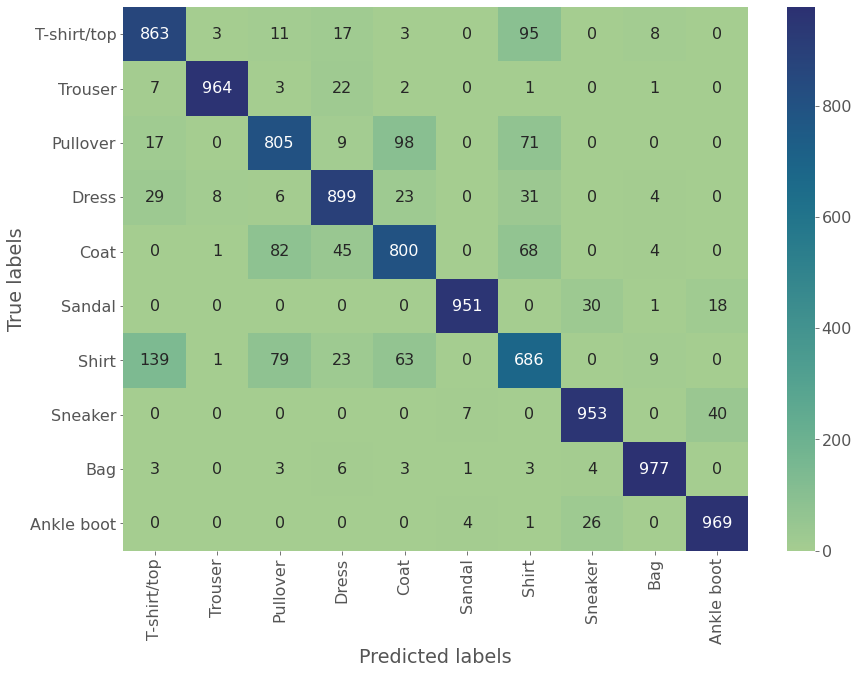

In [32]:
# Predict labels for test data
y_pred = model.predict(x_test, verbose = 0)

# Heatmap plot
plot_cm(y_pred, y_test)

# Delete model
clean_up(model)

##### *Remarks*

- In **epoch 33**, Model 3 attains its minimum validation loss. The plot suggests that the loss remains relatively stable over 100 epochs, indicating a potential opportunity to extend training for this model.

- Despite incorporating **Batch-Normalization**, intended to expedite and stabilize deep neural network training, we did not observe the expected behavior.

- The model achieves an accuracy of **88.7%**.